In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

## Device Agnostic Code

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

## Data PreProcessing

### Reading the data

In [3]:
data = pd.read_csv("./dataset-regression/student-mat.csv", sep=';')
data.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10


### Trimming the data

In [4]:
data = data[["studytime", "failures", "freetime", "absences", "G1", "G2", "G3"]]
data.head()

,studytime,failures,freetime,absences,G1,G2,G3
0,2,0,3,6,5,6,6
1,2,0,3,4,5,5,6
2,2,3,3,10,7,8,10
3,3,0,2,2,15,14,15
4,2,0,3,4,6,10,10


In [5]:
featues = data[["studytime", "failures", "freetime", "absences", "G1", "G2"]]
target = data["G3"]

In [6]:
# Scale the data
scaler = StandardScaler()
features_scaled = scaler.fit_transform(featues)

### Split the data

In [7]:
X_train, X_test, y_train, y_test = train_test_split(features_scaled, target, test_size=0.2, random_state=32)

In [8]:
# convert pandas series to numpy
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

In [9]:
x_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
x_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1,1).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1,1).to(device)

In [10]:
# checking the dimensions if they match

print(x_test_tensor.shape, x_train_tensor.shape)
print(y_test_tensor.shape, y_train_tensor.shape)

torch.Size([79, 6]) torch.Size([316, 6])
torch.Size([79, 1]) torch.Size([316, 1])


## Creating Regression Model 

In [11]:
class RegressionModel(nn.Module):
    def __init__(self):
        super(RegressionModel, self).__init__()
        self.layer_1 = nn.Linear(in_features=6, out_features=11)
        self.layer_2 = nn.Linear(in_features=11, out_features=12)
        self.layer_3 = nn.Linear(in_features=12, out_features=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model = RegressionModel().to(device)

### Setup Loss Function and Optimizer

In [12]:
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 10000

### Training Loop

In [13]:
loss_arr = []
epoch_arr = []

for epoch in range(epochs):
    model.train()

    # Forward pass
    outputs = model(x_test_tensor)
    loss = loss_fn(outputs, y_test_tensor)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch+1) % 500 == 0:
        loss_arr.append(loss)
        epoch_arr.append(epoch+1)
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

Epoch [500/10000], Loss: 7.1908
Epoch [1000/10000], Loss: 3.9300
Epoch [1500/10000], Loss: 3.1010
Epoch [2000/10000], Loss: 2.5663
Epoch [2500/10000], Loss: 1.9771
Epoch [3000/10000], Loss: 1.3487
Epoch [3500/10000], Loss: 1.0380
Epoch [4000/10000], Loss: 0.8385
Epoch [4500/10000], Loss: 0.7403
Epoch [5000/10000], Loss: 0.6752
Epoch [5500/10000], Loss: 0.6150
Epoch [6000/10000], Loss: 0.5580
Epoch [6500/10000], Loss: 0.4778
Epoch [7000/10000], Loss: 0.3651
Epoch [7500/10000], Loss: 0.1837
Epoch [8000/10000], Loss: 0.0522
Epoch [8500/10000], Loss: 0.0232
Epoch [9000/10000], Loss: 0.0180
Epoch [9500/10000], Loss: 0.0120
Epoch [10000/10000], Loss: 0.0092


### Plotting Loss Function

In [14]:
loss_arr = [ loss.item() for loss in loss_arr ]

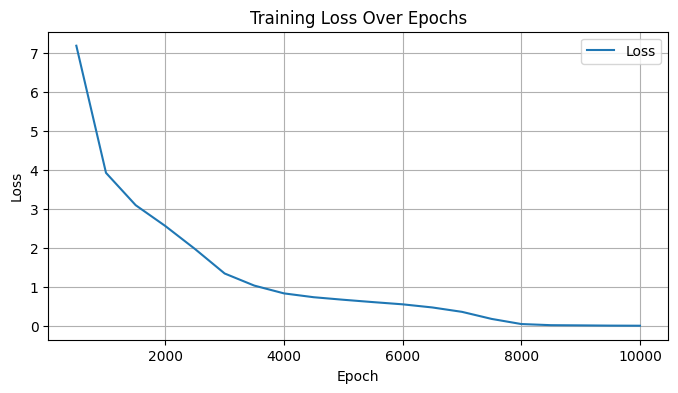

In [15]:
plt.figure(figsize=(8, 4))
plt.plot(epoch_arr, loss_arr ,label='Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

## Testing the Model

In [16]:
model.eval()

with torch.inference_mode():
    test_output = model(x_test_tensor)
    test_loss = loss_fn(test_output, y_test_tensor)
print(test_loss.item())


0.009244442917406559


## Comparing Actual and Predicted Data

In [17]:
# Create a DataFrame with actual and predicted data
test_data_df = pd.DataFrame({
    'Actual': y_test_tensor.numpy().flatten(),
    'Predicted': test_output.numpy().flatten()
})

test_data_df.head()

,Actual,Predicted
0,0.0,0.005568
1,14.0,14.028870
2,11.0,10.678598
3,11.0,11.002405
4,11.0,10.990538


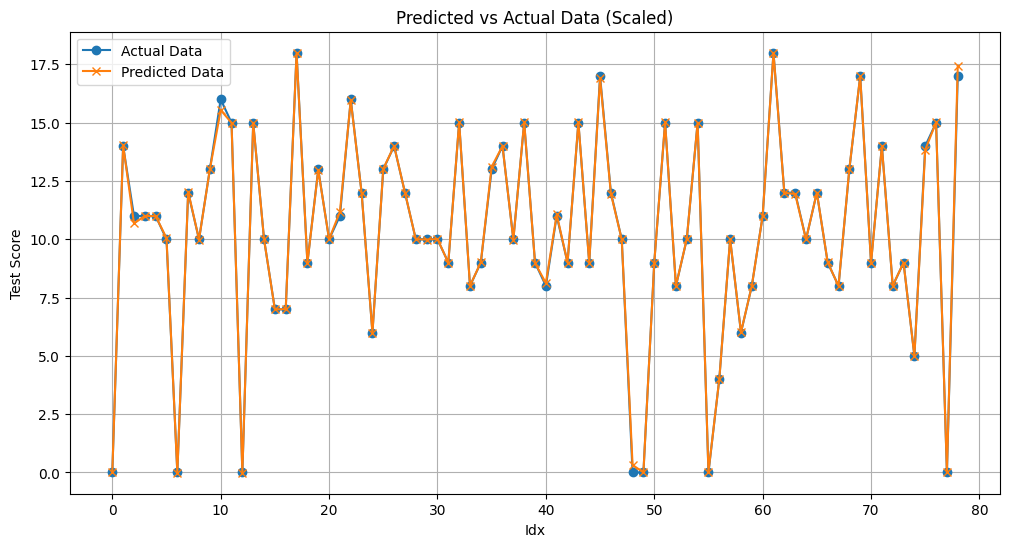

In [18]:
# Plotting the actual and predicted data

plt.figure(figsize=(12,6))
plt.plot(test_data_df['Actual'], label='Actual Data', marker='o')
plt.plot(test_data_df['Predicted'], label='Predicted Data', marker='x')
plt.ylabel('Test Score')
plt.xlabel('Idx')
plt.legend()
plt.title('Predicted vs Actual Data (Scaled)')
plt.grid()
plt.show()

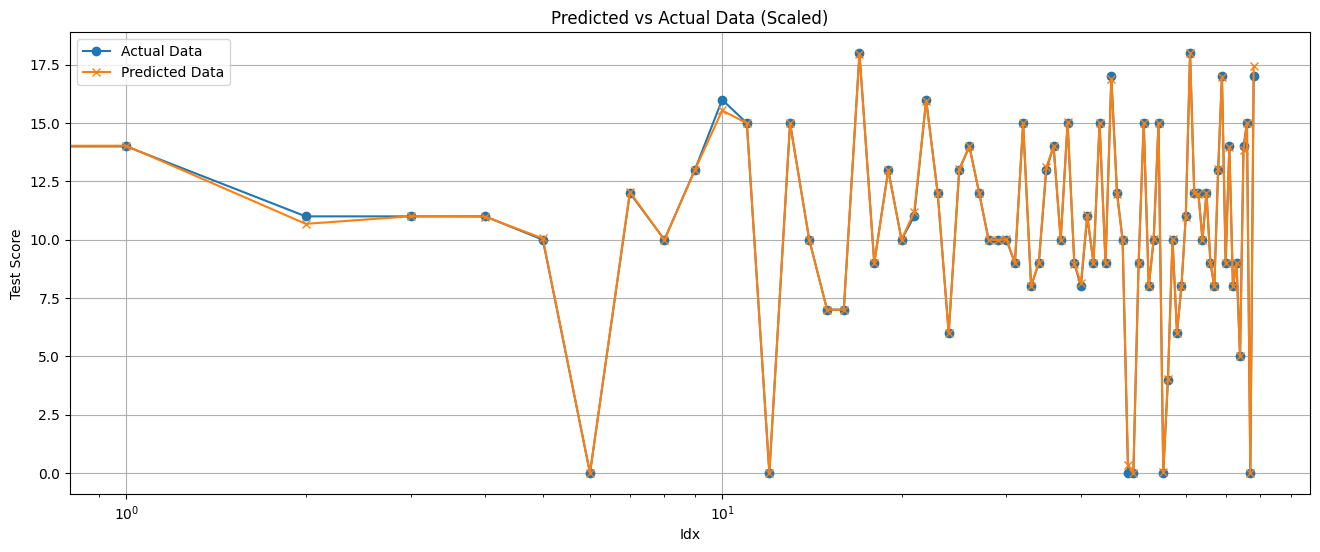

In [19]:
# Plotting the actual and predicted data

plt.figure(figsize=(16,6))
plt.plot(test_data_df['Actual'], label='Actual Data', marker='o')
plt.plot(test_data_df['Predicted'], label='Predicted Data', marker='x')
plt.ylabel('Test Score')
plt.xlabel('Idx')
plt.legend()
plt.xscale('log')
plt.title('Predicted vs Actual Data (Scaled)')
plt.grid()
plt.show()

## R2 Score

r-squared shows how well the data fit the regression model (the goodness of fit)

<img src="https://i0.wp.com/www.fairlynerdy.com/wp-content/uploads/2017/01/r_squared_5.png?resize=625%2C193" alt="error function" width="500"/>


In [20]:
r2 = r2_score(y_test_tensor.numpy(), test_output.numpy())
print(f'R2 Score of the model is {r2}')

R2 Score of the model is 0.99952632188797
